In [ ]:
import os
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pkdarabi/vehicle-detection-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 262M/262M [00:14<00:00, 19.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pkdarabi/vehicle-detection-image-dataset/versions/7


In [ ]:
file_path = os.path.join(path, 'No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/train/_annotations.coco.json')

# Read the Json Annotations file
with open(file_path, 'r') as file:
    coco_data = json.load(file)

# Extract the categories
categories = {category['id']: category['name'] for category in coco_data['categories']}

print(categories)


{0: 'cars', 1: 'Bus', 2: 'Car', 3: 'Motorcycle', 4: 'Pickup', 5: 'Truck'}


In [ ]:
def load_coco_images_fix(coco_data, image_dir):
    images = []
    annotations = []
    for image_info in coco_data['images']:
        image_path = os.path.join(image_dir, image_info['file_name'])
        image = cv2.imread(image_path)
        if image is not None:
            original_height, original_width = image.shape[:2] # Get original image dimensions
            image = cv2.resize(image, (224, 224)) / 255.0
            images.append(image)
            # Get the associated annotation
            image_annotations = [annotation for annotation in coco_data['annotations'] if annotation['image_id'] == image_info['id']]
            # Get the annotation for the bounding box and rescale coordinates
            annotations.append({
                'image_id': image_info['id'],
                'bboxes': [
                    (
                        [
                            int(annotation['bbox'][0] * 224 / original_width),  # Rescale x
                            int(annotation['bbox'][1] * 224 / original_height), # Rescale y
                            int(annotation['bbox'][2] * 224 / original_width),  # Rescale width
                            int(annotation['bbox'][3] * 224 / original_height)   # Rescale height
                        ],
                        annotation['category_id']
                    ) for annotation in image_annotations
                ]
            })
    return np.array(images), np.array(annotations)

Categories: {0: 'cars', 1: 'Bus', 2: 'Car', 3: 'Motorcycle', 4: 'Pickup', 5: 'Truck'}
First image shape: (224, 224, 3)
First image annotations: {'image_id': 0, 'bboxes': [([108, 172, 7, 27], 3), ([73, 145, 12, 21], 2), ([52, 140, 14, 21], 2), ([11, 105, 11, 14], 2), ([6, 99, 12, 11], 2), ([25, 87, 8, 8], 2), ([35, 87, 7, 10], 2), ([4, 88, 3, 9], 3), ([30, 83, 2, 5], 3), ([42, 81, 5, 6], 2), ([52, 87, 6, 6], 2), ([56, 84, 5, 6], 2), ([52, 79, 5, 8], 4), ([103, 102, 6, 9], 2), ([87, 108, 7, 10], 2), ([75, 105, 7, 9], 2), ([91, 100, 5, 8], 2), ([84, 96, 5, 7], 2), ([86, 90, 5, 7], 2), ([94, 89, 5, 7], 2), ([98, 83, 3, 5], 2), ([113, 89, 4, 7], 2), ([101, 81, 7, 16], 1), ([101, 81, 2, 3], 2), ([104, 77, 2, 3], 2), ([109, 77, 2, 3], 2), ([114, 73, 2, 3], 2), ([117, 74, 2, 4], 4), ([111, 73, 2, 3], 2), ([121, 74, 1, 3], 3), ([120, 74, 0, 3], 3), ([121, 72, 1, 2], 2), ([123, 71, 1, 2], 2), ([126, 71, 1, 2], 3)]}


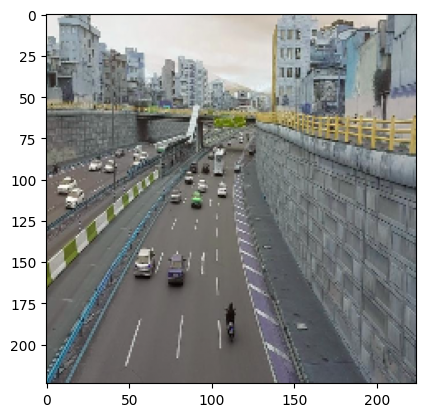

In [ ]:
images_dir = os.path.join(path, 'No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/train')
X_images, y_annotations = load_coco_images_fix(coco_data, images_dir)

# Make sure the output is as expected
print(f"Categories: {categories}")
print(f"First image shape: {X_images[0].shape}")
print(f"First image annotations: {y_annotations[0]}")

# Display first image
plt.imshow(X_images[0])
plt.show()

## EDA
The next sections take the processed images and annotations and do some EDA and preprocessing on them. This will help guide training and model design decisions.

In [ ]:
# Print the category counts
category_counts = [ann['category_id'] for ann in coco_data['annotations']]
value_counts_series = pd.Series(category_counts).value_counts()

# Print Category name
print(categories)

# Replace category IDs with names in the value counts
value_counts_with_names = value_counts_series.rename(index=categories)

# Print the updated value counts
print(value_counts_with_names)

{0: 'cars', 1: 'Bus', 2: 'Car', 3: 'Motorcycle', 4: 'Pickup', 5: 'Truck'}
Car           1527
Motorcycle     281
Pickup         190
Truck           47
Bus             24
Name: count, dtype: int64


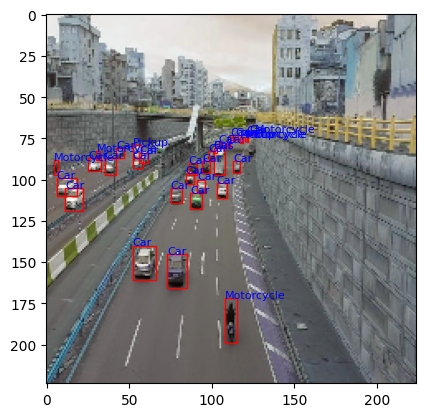

In [ ]:
# Visualize a random subset of images with the bounding boxes to ensure the data looks good
def visualize_image_with_bboxes(image, annotations, categories):
    plt.imshow(image)
    # Access the 'bboxes' key within the annotations dictionary
    for bbox, category_id in annotations['bboxes']:
        x, y, w, h = map(int, bbox)
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', fill=False))
        plt.text(x, y, categories[category_id], color='blue', fontsize=8)
    plt.show()

visualize_image_with_bboxes(X_images[0], y_annotations[0], categories)


In [ ]:
def check_bbox_validity(bbox, image_shape):
    x_min, y_min, width, height = bbox
    return (
        0 <= x_min < image_shape[1] and
        0 <= y_min < image_shape[0] and
        width > 0 and
        height > 0 and
        x_min + width <= image_shape[1] and
        y_min + height <= image_shape[0]
    )

valid_bboxes = [check_bbox_validity(ann['bbox'], (640, 640)) for ann in coco_data['annotations']]
print(f"Invalid bboxes: {len(valid_bboxes) - sum(valid_bboxes)}")


Invalid bboxes: 0


## Custom Datagen
The next section builds a custom datagenerator class for this dataset in particular.

In [ ]:
# Define the R-CNN model
def create_rcnn_model(num_classes):
    # Use a pre-trained ResNet50 as the base model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers for region proposal and classification
    x = base_model.output
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    # Region Proposal Network (RPN) branch
    rpn_out = Dense(4, activation='linear', name='rpn_bbox_regression')(x)  # Predict 4 coordinates for each object
    rpn_class = Dense(num_classes, activation='softmax', name='rpn_class')(x)

    # Classification branch
    classifier_out = Dense(num_classes, activation='softmax', name='class')(x)

    # Combine outputs
    model = Model(inputs=base_model.input, outputs=[rpn_out, rpn_class, classifier_out])

    return model

num_classes = len(categories) + 1 # Include background class
print(f"Number of classes: {num_classes}")
# Create the R-CNN model
rcnn_model = create_rcnn_model(num_classes)
rcnn_model.summary()

# Compile the model
optimizer = Adam(learning_rate=1e-4) # Start with a low learning rate
rcnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'rpn_bbox_regression': 'mse',  # Bounding box regression
        'rpn_class': 'categorical_crossentropy',  # RPN classification
        'class': 'sparse_categorical_crossentropy'  # Object classification
    },
    metrics={
        'class': 'accuracy'
    }
)



Number of classes: 7


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 33,108,370 (126.30 MB)

 Trainable params: 9,520,658 (36.32 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.utils import to_categorical
def prepare_data(X_images, y_annotations, categories, num_classes):
    """
    Prepares the data for training an R-CNN model.

    Args:
        X_images: NumPy array of images.
        y_annotations: NumPy array of annotations.
        categories: Dictionary mapping category IDs to category names.

    Returns:
        Tuple: A tuple containing the prepared images, bounding boxes, and class labels.
    """

    num_samples = len(X_images)
    image_data = []
    bbox_data = []
    class_labels = []
    rpn_labels = []

    for i in range(num_samples):
      image = X_images[i]
      annotations = y_annotations[i]
      ## ADDEDTHIS
      bbox_array = np.zeros((num_classes * 4,), dtype=np.float32)

      #check if there are any bounding boxes to avoid crashing
      if len(annotations['bboxes']) > 0:
          for bbox, category_id in annotations['bboxes']:
              x, y, w, h = bbox
              bbox_array[category_id * 4:(category_id + 1) * 4] = [x, y, w, h]  # Set bbox for the corresponding class
              rpn_labels.append(category_id)
          image_data.append(image)  # Append the image
          bbox_data.append(bbox_array) # Append bounding box
          class_labels.append(category_id) # Append class label

    # Convert RPN labels to one-hot encoding
    y_rpn = to_categorical(rpn_labels, num_classes=num_classes)

    # Ensure y_rpn, y_bbox_data, and y_class_labels have the same number of samples
    min_samples = min(len(image_data), len(bbox_data), len(class_labels), len(rpn_labels))
    image_data = image_data[:min_samples]
    bbox_data = bbox_data[:min_samples]
    class_labels = class_labels[:min_samples]
    y_rpn = y_rpn[:min_samples]

    return np.array(image_data), np.array(bbox_data), np.array(class_labels), y_rpn

    # return np.array(image_data), np.array(bbox_data), np.array(class_labels)


# Prepare the data
X_train, y_bbox_paded, y_class, y_rpn = prepare_data(X_images, y_annotations, categories, num_classes)
# y_rpn = to_categorical(y_rpn, num_classes=num_classes)

y_train = [y_bbox_paded, y_rpn, y_class]
# print(f"X_images shape: {X_images.shape}")
# print(f"X_train shape: {X_train.shape}")
# print(f"y_bbox shape: {y_bbox.shape}")
# print(f"y_class shape: {y_class.shape}")

# y_train = [y_bbox, y_class]

# print(f"y_train shape: {len(y_train)}")

In [ ]:
def prepare_data(X_images, y_annotations, categories, num_classes):
    num_samples = len(X_images)
    image_data = []
    bbox_data = []
    class_labels = []
    rpn_labels = []

    for i in range(num_samples):
        image = X_images[i]
        annotations = y_annotations[i]

        # Create an array for bounding boxes (4 values per object, not num_classes * 4)
        bbox_array = np.zeros((4,), dtype=np.float32)

        if len(annotations['bboxes']) > 0:
            for bbox, category_id in annotations['bboxes']:
                x, y, w, h = bbox
                bbox_array
                # Correct bounding box assignment to use just 4 values
                # bbox_array[category_id * 4: (category_id + 1) * 4] = [x, y, w, h]
                rpn_labels.append(category_id)
            image_data.append(image)
            bbox_data.append(bbox_array)
            class_labels.append(category_id)

    y_rpn = to_categorical(rpn_labels, num_classes=num_classes)

    # Ensure all data arrays have the same size
    min_samples = min(len(image_data), len(bbox_data), len(class_labels), len(rpn_labels))
    image_data = image_data[:min_samples]
    bbox_data = bbox_data[:min_samples]
    class_labels = class_labels[:min_samples]
    y_rpn = y_rpn[:min_samples]

    return np.array(image_data), np.array(bbox_data), np.array(class_labels), y_rpn

X_train, y_bbox_paded, y_class, y_rpn = prepare_data(X_images, y_annotations, categories, num_classes)
# y_rpn = to_categorical(y_rpn, num_classes=num_classes)

y_train = [y_bbox_paded, y_rpn, y_class]

In [ ]:
print(f"y_clas entries: {y_class[:5]}")
print("Number of categories:", len(categories))
print("num_classes:", num_classes)

print(f"y_train shapes: {[y.shape for y in y_train]}")



y_clas entries: [3 3 2 3 2]
Number of categories: 6
num_classes: 7
y_train shapes: [(101, 4), (101, 7), (101,)]


In [ ]:
def prepare_data(X_images, y_annotations, categories, num_classes):
    """
    Prepares the data for training an R-CNN model.

    Args:
        X_images: NumPy array of images.
        y_annotations: NumPy array of annotations.
        categories: Dictionary mapping category IDs to category names.
        num_classes: Number of classes in the dataset.

    Returns:
        Tuple: A tuple containing the prepared images, bounding boxes, and class labels.
    """
    num_samples = len(X_images)
    image_data = []
    bbox_data = []
    class_labels = []

    for i in range(num_samples):
        image = X_images[i]
        annotations = y_annotations[i]

        # Initialize an empty array for bounding box data (num_classes * 4)
        bbox_array = np.zeros((num_classes * 4,), dtype=np.float32)

        # Check if there are any bounding boxes to avoid crashing
        if len(annotations['bboxes']) > 0:
            for bbox, category_id in annotations['bboxes']:
                x, y, w, h = bbox
                bbox_array[category_id * 4:(category_id + 1) * 4] = [x, y, w, h]  # Set bbox for the corresponding class

        image_data.append(image)  # Append the image
        bbox_data.append(bbox_array)  # Append the modified bounding box array
        class_labels.append(category_id)  # Append class label

    return np.array(image_data), np.array(bbox_data), np.array(class_labels)

X_train, y_bbox_padded, y_rpn_one_hot = prepare_data(X_images, y_annotations, categories, num_classes)


from tensorflow.keras.utils import to_categorical

# Convert y_rpn to one-hot encoding (num_classes includes background)
y_rpn = to_categorical(y_rpn, num_classes=num_classes)

print(f"X_train shape: {X_train.shape}")
print(f"y_bbox shape: {y_bbox_padded.shape}")
# print(f"y_class shape: {y_class.shape}")
print(f"y_rpn shape: {y_rpn.shape}")


X_train shape: (102, 224, 224, 3)
y_bbox shape: (102, 28)
y_rpn shape: (2069, 7, 7, 7)


{0: 'cars', 1: 'Bus', 2: 'Car', 3: 'Motorcycle', 4: 'Pickup', 5: 'Truck'}
Categories: {0: 'cars', 1: 'Bus', 2: 'Car', 3: 'Motorcycle', 4: 'Pickup', 5: 'Truck'}
First image shape: (224, 224, 3)
First image annotations: {'image_id': 0, 'bboxes': [([140, 55, 21, 14], 4)]}


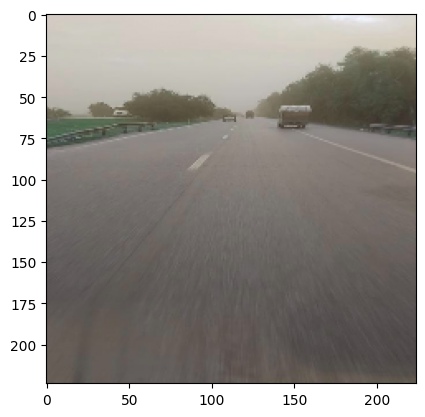

In [ ]:

## Validation
file_path = os.path.join(path, 'No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/valid/_annotations.coco.json')

# Read the Json Annotations file
with open(file_path, 'r') as file:
    coco_data = json.load(file)

# Extract the categories
categories = {category['id']: category['name'] for category in coco_data['categories']}

print(categories)

images_dir = os.path.join(path, 'No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/valid')
X_val_images, y_val_annotations = load_coco_images_fix(coco_data, images_dir)

# Make sure the output is as expected
print(f"Categories: {categories}")
print(f"First image shape: {X_val_images[0].shape}")
print(f"First image annotations: {y_val_annotations[0]}")

# Display first image
plt.imshow(X_val_images[0])
plt.show()

X_val, y_val_bbox, y_val_class, y_val_rpn = prepare_data(X_val_images, y_val_annotations, categories)
y_val_rpn = to_categorical(y_val_rpn, num_classes=num_classes)


In [ ]:
num_classes = 7
num_samples = y_bbox.shape[0]

# Initialize y_bbox_padded with zeros
y_bbox_padded = np.zeros((num_samples, num_classes * 4))

# Assign the bounding box values for the target class
for i in range(num_samples):
    class_id = y_class[i]  # The class index for the bounding box
    y_bbox_padded[i, class_id * 4:(class_id + 1) * 4] = y_bbox[i]

In [ ]:
y_class -=1


In [ ]:
print(y_rpn.shape)
print(y_class.shape)

print(f"rpn_bbox_regression output shape: {rcnn_model.get_layer('rpn_bbox_regression').output.shape}")
print(f"rpn_class output shape: {rcnn_model.get_layer('rpn_class').output.shape}")
print(f"class output shape: {rcnn_model.get_layer('class').output.shape}")

print("y_bbox_padded shape:", y_bbox_padded.shape)
print("y_rpn shape:", y_rpn.shape)
print("y_class shape:", y_class.shape)

print("Sample image:", X_train[0])  # Check the image data
print("Sample bbox:", y_bbox_padded[0])  # Check the bounding box data
print("Sample class:", y_class[0])  # Check the class labels
print("Sample rpn:", y_rpn[0])  # Check the RPN data


(101, 7)
(101,)
rpn_bbox_regression output shape: (None, 4)
rpn_class output shape: (None, 7)
class output shape: (None, 7)
y_bbox_padded shape: (2069, 28)
y_rpn shape: (101, 7)
y_class shape: (101,)
Sample image: [[[0.9254902  0.91764706 0.91372549]
  [0.9254902  0.91764706 0.91372549]
  [0.9254902  0.91764706 0.91372549]
  ...
  [0.54901961 0.59607843 0.61176471]
  [0.57254902 0.61960784 0.63529412]
  [0.54509804 0.59215686 0.60784314]]

 [[0.9254902  0.91764706 0.91372549]
  [0.9254902  0.91764706 0.91372549]
  [0.9254902  0.91764706 0.91372549]
  ...
  [0.52941176 0.57647059 0.59215686]
  [0.56470588 0.61176471 0.62745098]
  [0.57647059 0.62352941 0.63921569]]

 [[0.9254902  0.91764706 0.91372549]
  [0.9254902  0.91764706 0.91372549]
  [0.9254902  0.91764706 0.91372549]
  ...
  [0.52941176 0.57647059 0.59215686]
  [0.58823529 0.63529412 0.65098039]
  [0.58823529 0.63529412 0.65098039]]

 ...

 [[0.40392157 0.66666667 0.74901961]
  [0.1372549  0.39215686 0.49803922]
  [0.21176471 0.

In [ ]:
history = rcnn_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10
)
# history = rcnn_model.fit(
#     X_train,
#     {
#         'rpn_bbox_regression': y_bbox,
#         'rpn_class': np.zeros((len(y_bbox), num_classes)),  # Placeholder RPN labels
#         'class': y_class
#     },
#     batch_size=32,
#     epochs=10
# )



Epoch 1/10


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 4), output.shape=(None, 4)

{0: 'cars', 1: 'Bus', 2: 'Car', 3: 'Motorcycle', 4: 'Pickup', 5: 'Truck'}
Categories: {0: 'cars', 1: 'Bus', 2: 'Car', 3: 'Motorcycle', 4: 'Pickup', 5: 'Truck'}
First image shape: (224, 224, 3)
First image annotations: {'image_id': 0, 'bboxes': [([199, 0, 24, 61], 5), ([17, 38, 95, 42], 2)]}


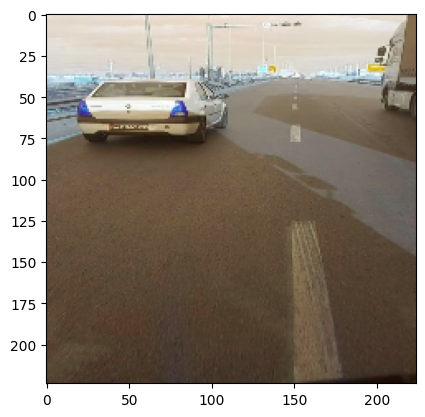

{0: 'cars', 1: 'Bus', 2: 'Car', 3: 'Motorcycle', 4: 'Pickup', 5: 'Truck'}
Categories: {0: 'cars', 1: 'Bus', 2: 'Car', 3: 'Motorcycle', 4: 'Pickup', 5: 'Truck'}
First image shape: (224, 224, 3)
First image annotations: {'image_id': 0, 'bboxes': [([140, 55, 21, 14], 4)]}


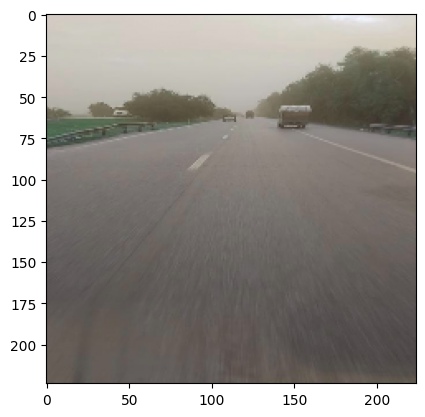

In [ ]:
# Get Test and Validation Data
file_path = os.path.join(path, 'No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/test/_annotations.coco.json')

# Read the Json Annotations file
with open(file_path, 'r') as file:
    coco_data = json.load(file)

# Extract the categories
categories = {category['id']: category['name'] for category in coco_data['categories']}

print(categories)

images_dir = os.path.join(path, 'No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/test')
X_test_images, y_test_annotations = load_coco_images_fix(coco_data, images_dir)

# Make sure the output is as expected
print(f"Categories: {categories}")
print(f"First image shape: {X_test_images[0].shape}")
print(f"First image annotations: {y_test_annotations[0]}")

# Display first image
plt.imshow(X_test_images[0])
plt.show()



In [ ]:
X_test, y_test_bbox, y_test_class = prepare_data(X_test_images, y_test_annotations, categories)


In [ ]:
# Evaluate the model
results = rcnn_model.evaluate(X_val, y_val_class)

# 'results' only contains the loss, not accuracy directly.
print("Test loss:", results)

# If your model has an accuracy metric, it might be accessible through model.metrics_names
# For example, if 'accuracy' is in the metrics names:
if 'accuracy' in rcnn_model.metrics_names:
    accuracy = rcnn_model.evaluate(X_val, y_val_class, return_dict=True)['accuracy']
    print("Accuracy:", accuracy)
else:
    print("Accuracy metric not found in model.metrics_names")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 4.5056
Test loss: 4.392498016357422
Accuracy metric not found in model.metrics_names


In [ ]:
# Make predictions
predictions = rcnn_model.predict(X_test)

# Print model summary
rcnn_model.summary()

# Print the first prediction
print("First prediction:", predictions[0])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 52,481,536 (200.20 MB)

 Trainable params: 9,631,274 (36.74 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 19,262,550 (73.48 MB)

First prediction: [[-4.9437404 -8.898224  30.91289   ...  3.4942648 -7.590059  -2.8361962]
 [-4.9437404 -8.898224  30.91289   ...  3.4942648 -7.590059  -2.8361962]
 [-5.009745  -9.145338  31.861916  ...  3.8795176 -7.7338085 -2.8405745]
 ...
 [-4.952081  -9.034419  31.729445  ...  3.8613708 -7.7319627 -2.9336324]
 [-4.952081  -9.034419  31.729445  ...  3.8613708 -7.7319627 -2.9336324]
 [-4.952081  -9.034419  31.729445  ...  3.8613708 -7.7319627 -2.9336324]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


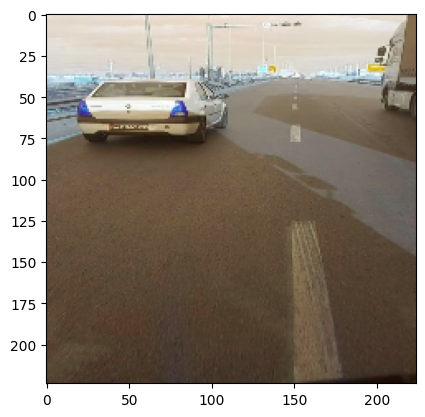

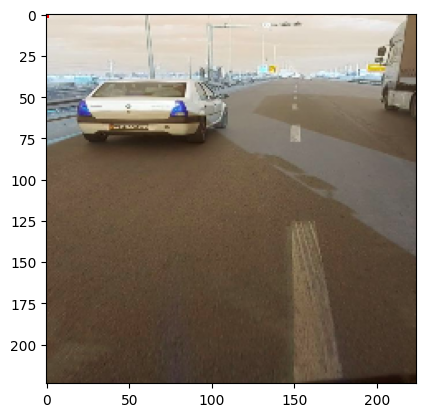

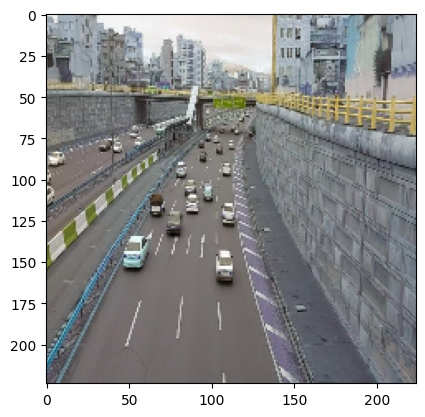

In [ ]:
# Make predictions
predictions = rcnn_model.predict(X_test)

# Visualize predictions
for i, image_predictions in enumerate(predictions):  # Iterate over each image's predictions
    image = X_test[i]

    # Iterate over potential bounding boxes in the image's predictions
    for bbox_data in image_predictions:
        x, y, width, height = bbox_data[:4]  # Extract the first 4 elements as bbox coordinates

        # Now you have (x, y, width, height) for a potential bounding box
        plt.imshow(image)
        plt.gca().add_patch(plt.Rectangle((x, y), width, height, edgecolor='red', fill=False))
    plt.show()
